# Boosting AdaBoost

Simple Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Adaptive Boosting Algorithm

In [2]:
def default_weights(n):
    return np.full(n,1/n)

$$\epsilon_t = \sum_{i=1}^nw_t(i)\mathbb{1}\{y_i\ne f_t(x_i)\}$$  

In [3]:
def calc_epsilon(y_true, y_pred, weights):
    summ=0
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            summ=summ+weights[i]
    return np.float(summ)

$$\alpha_t = \frac12ln(\frac{1-\epsilon_t}{\epsilon_t})$$  

In [4]:
def calc_alpha(epsilon):
    if epsilon==0:
        return np.inf
    else:
        return 0.5*np.log((1-epsilon)/epsilon)

In [5]:
def boot_strap_selection(X, y, weights):
    bss_indicies = np.random.choice(range(len(y)), size = len(y), p = weights)
    
    # Subset arrays with indicies
    return X[bss_indicies,:], y[bss_indicies]

### Example of use
X = np.array([[1,1],[2,2],[3,3],[4,4],[5,5]])
y = np.array([1,0,1,0,1])
weights = np.array([.35,.1,.1,.35,.1])

print(boot_strap_selection(X,y, weights))    

(array([[5, 5],
       [5, 5],
       [1, 1],
       [2, 2],
       [4, 4]]), array([1, 1, 1, 0, 0]))


$$w_{t+1}(i) = \frac{\hat{w}_{t+1}(i)}{\sum_j\hat{w}_{t+1}(j)}$$  


$$\hat{w}_{t+1}(i) = w_t(i)e^{-\alpha_ty_if_t(x_i)}$$

In [6]:
def update_weights(weights, alpha, y_true, y_pred):
    def target_for_weight_update(y):
        toRet=y.copy()
        toRet[toRet==0]=-1
        return toRet
    y=target_for_weight_update(y_true)
    pred=target_for_weight_update(y_pred)
    weights=weights*np.exp(-alpha*y*pred)
    weights=weights/sum(weights)
    return weights

Prediction from boosted trees


In [7]:
def predict(X, est_dict):
    fin_preds=np.zeros(X.shape[0])
    for k in est_dict:
        preds=est_dict[k][0].predict(X)
        preds[preds<1]=-1
        preds=preds*est_dict[k][1]
        fin_preds +=preds
    fin_preds[fin_preds>=0]=1
    fin_preds[fin_preds<0]=0
    return fin_preds



$$f_{boost}(x_0) = sign(\sum_{t=1}^T\alpha_tf_t(X_0))$$  


In [8]:
def predict(X, est_dict):
    fin_preds=np.zeros(X.shape[0])
    for k in est_dict:
        preds=est_dict[k][0].predict(X)
        preds[preds<1]=-1
        preds=preds*est_dict[k][1]
        fin_preds +=preds
    fin_preds[fin_preds>=0]=1
    fin_preds[fin_preds<0]=0
    return fin_preds

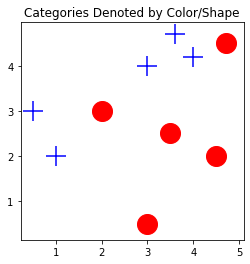

df:
      x    y  classification
0  0.5  3.0               1
1  1.0  2.0               1
2  3.0  0.5              -1
3  2.0  3.0              -1
4  3.0  4.0               1
5  3.5  2.5              -1
6  3.6  4.7               1
7  4.0  4.2               1
8  4.5  2.0              -1
9  4.7  4.5              -1 



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [9]:
#provided, shortened
from sklearn.tree import DecisionTreeClassifier

def simple_tree():
    return DecisionTreeClassifier(criterion = 'entropy', max_depth= 1)

#example
pts = [[.5, 3,1],[1,2,1],[3,.5,-1],[2,3,-1],[3,4,1],
 [3.5,2.5,-1],[3.6,4.7,1],[4,4.2,1],[4.5,2,-1],[4.7,4.5,-1]]

df = pd.DataFrame(pts, columns = ['x','y','classification'])

# Plotting by category

b = df[df.classification ==1]
r = df[df.classification ==-1]
plt.figure(figsize = (4,4))
plt.scatter(b.x, b.y, color = 'b', marker="+", s = 400)
plt.scatter(r.x, r.y, color = 'r', marker = "o", s = 400)
plt.title("Categories Denoted by Color/Shape")
plt.show()


print("df:\n",df, "\n")

### split out X and y
X = df[['x','y']]

# Change from -1 and 1 to 0 and 1
y = np.array([1 if x == 1 else 0 for x in df['classification']])

### Split data in half
X1 = X.iloc[:len(X.index)//2, :]
X2 = X.iloc[len(X.index)//2:, :]

y1 = y[:len(y)//2]
y2 = y[len(X)//2:]


### Fit classifier to both sets of data, save to dictionary:

tree_dict = {}

tree1 = simple_tree()
tree1.fit(X1,y1)


### made up alpha, for example
alpha1 = .6
tree_dict[1] = (tree1, alpha1)

tree2 = simple_tree()
tree2.fit(X2,y2)

# Building Adaptive Boosting

In [10]:
def simple_adaboost_fit(X,y, n_estimators):
    def simple_tree():
        return DecisionTreeClassifier(criterion = 'entropy', max_depth= 1)
    
    # Create default weights array where all are equal to 1/n
    weights = default_weights(len(y)) ### <------
    
    est_dict = {}
    for i in range(n_estimators):
        # Create bootstrap sample
        bs_X, bs_y = boot_strap_selection(X, y, weights)
        
#         print(bs_X,bs_y)
#         break
        mod = simple_tree()
        mod.fit(bs_X, bs_y)
        
        # Note: Predicting on all values of X, NOT boot-strap
        preds = mod.predict(X)
        
        epsilon = calc_epsilon(y, preds, weights) ### <------
        alpha = calc_alpha(epsilon) ### <------
        
        # Note that the i+1-th model will be keyed to the int i,
        # and will store a tuple of the fit model and the alpha value
        est_dict[i] = (mod, alpha)
        
        weights = update_weights(weights, alpha, y, preds) ### <------
    
    return est_dict
#     return bs_X

In [11]:
col_names = [
"age", "workclass", "fnlwgt", "education",
"education-num", "marital-status", "occupation", "relationship",
"race", "sex", "capital-gain", "capital-loss", "hours-per-week",
"native-country", "income"
]

data_path = "./week7dataset.data"

data = pd.read_csv(data_path, header = None, names = col_names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
#provided, altered
def preprocess_census(X_train, X_test, y_train, y_test):

    ### Hardcode variables which need categorical encoding
    to_encode = ["workclass", "occupation", "sex"]

    ### Find top categories in categorical columns
    ### Used for dropping majority class to prevent multi-colinearity
    top_categories = []

    for col in to_encode:
        top_categories.append(X_train[col].value_counts().index[0])

    ### Create and fit one-hot encoder for categoricals
    OHE = OneHotEncoder(sparse = False)
    OHE.fit(X_train[to_encode])

    ## Create and fit Label encoder for target
    LabEnc = LabelEncoder()
    LabEnc.fit(y_train)

    def create_encoded_df(X, to_encode = to_encode, OHE = OHE, top_categories = top_categories):
        # Return columns which need encoding.
        def return_encoded_cols(X, to_encode = to_encode, OHE = OHE, top_categories = top_categories):
            # Use onehotencoder to transform.
            # Use "categories" to name
            toRet = pd.DataFrame(OHE.transform(X[to_encode]), columns = np.concatenate(OHE.categories_))

            # Drop top_categories and return
            return toRet.drop(top_categories, axis = 1)

        # create encoded columns
        ret_cols = return_encoded_cols(X)

        # Drop columns that were encoded
        dr_enc = X.drop(to_encode, axis = 1)

        # Concatenate values
        # use index from original data
        # use combined column names
#         return pd.DataFrame(np.concatenate([ret_cols.values, dr_enc.values],axis = 1),
#                             index = dr_enc.index,
#                             columns = list(ret_cols.columns) + list(dr_enc.columns))

        return ret_cols

    def encode_target(y, LabEnc = LabEnc):
        # Use label encoder, and supply with original index
        return pd.Series(LabEnc.transform(y), index= y.index)

    return create_encoded_df(X_train), create_encoded_df(X_test), encode_target(y_train), encode_target(y_test)

In [14]:
target = data['income']
predictors = data.drop("income", axis = 'columns')

X_train, X_test, y_train, y_test = preprocess_census(*train_test_split(predictors, target, test_size = .2))

Fitting models to data

In [15]:
from sklearn.metrics import classification_report

In [16]:
d = simple_adaboost_fit(X_train.values.copy(), y_train.values.copy(), 50)
preds = predict(X_test, d)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.95      0.87      4936
           1       0.60      0.22      0.32      1577

    accuracy                           0.78      6513
   macro avg       0.70      0.59      0.59      6513
weighted avg       0.75      0.78      0.73      6513

